In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno  # optional but helpful
import plotly.express as px
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc as calc_auc,
    precision_score, recall_score, brier_score_loss, roc_curve
)
from sklearn.inspection import PartialDependenceDisplay

In [2]:
file_path = 'data/your_data_file.csv'
df = pd.read_csv(file_path)

print("Shape:", df.shape)
print(df.head())
print(df.info())
print(df.describe(include='all'))

df = df.rename(columns={
    "NumberOfTime30-59DaysPastDueNotWorse": "Num30_59_DPD",
    "NumberOfTime60-89DaysPastDueNotWorse": "Num60_89_DPD",
    "NumberOfTimes90DaysLate": "Num90Plus_DPD",
    "NumberRealEstateLoansOrLines": "NumRealEstateLoans",
    "NumberOfOpenCreditLinesAndLoans": "NumOpenCredit",
    "RevolvingUtilizationOfUnsecuredLines": "RevUtil",
    "NumberOfDependents": "NumDependents"
})

Shape: (150000, 12)
   Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0           1                 1                              0.766127   45   
1           2                 0                              0.957151   40   
2           3                 0                              0.658180   38   
3           4                 0                              0.233810   30   
4           5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               1


Missing values per column:
MonthlyIncome         29731
NumDependents          3924
Unnamed: 0                0
SeriousDlqin2yrs          0
age                       0
RevUtil                   0
DebtRatio                 0
Num30_59_DPD              0
NumOpenCredit             0
Num90Plus_DPD             0
NumRealEstateLoans        0
Num60_89_DPD              0
dtype: int64


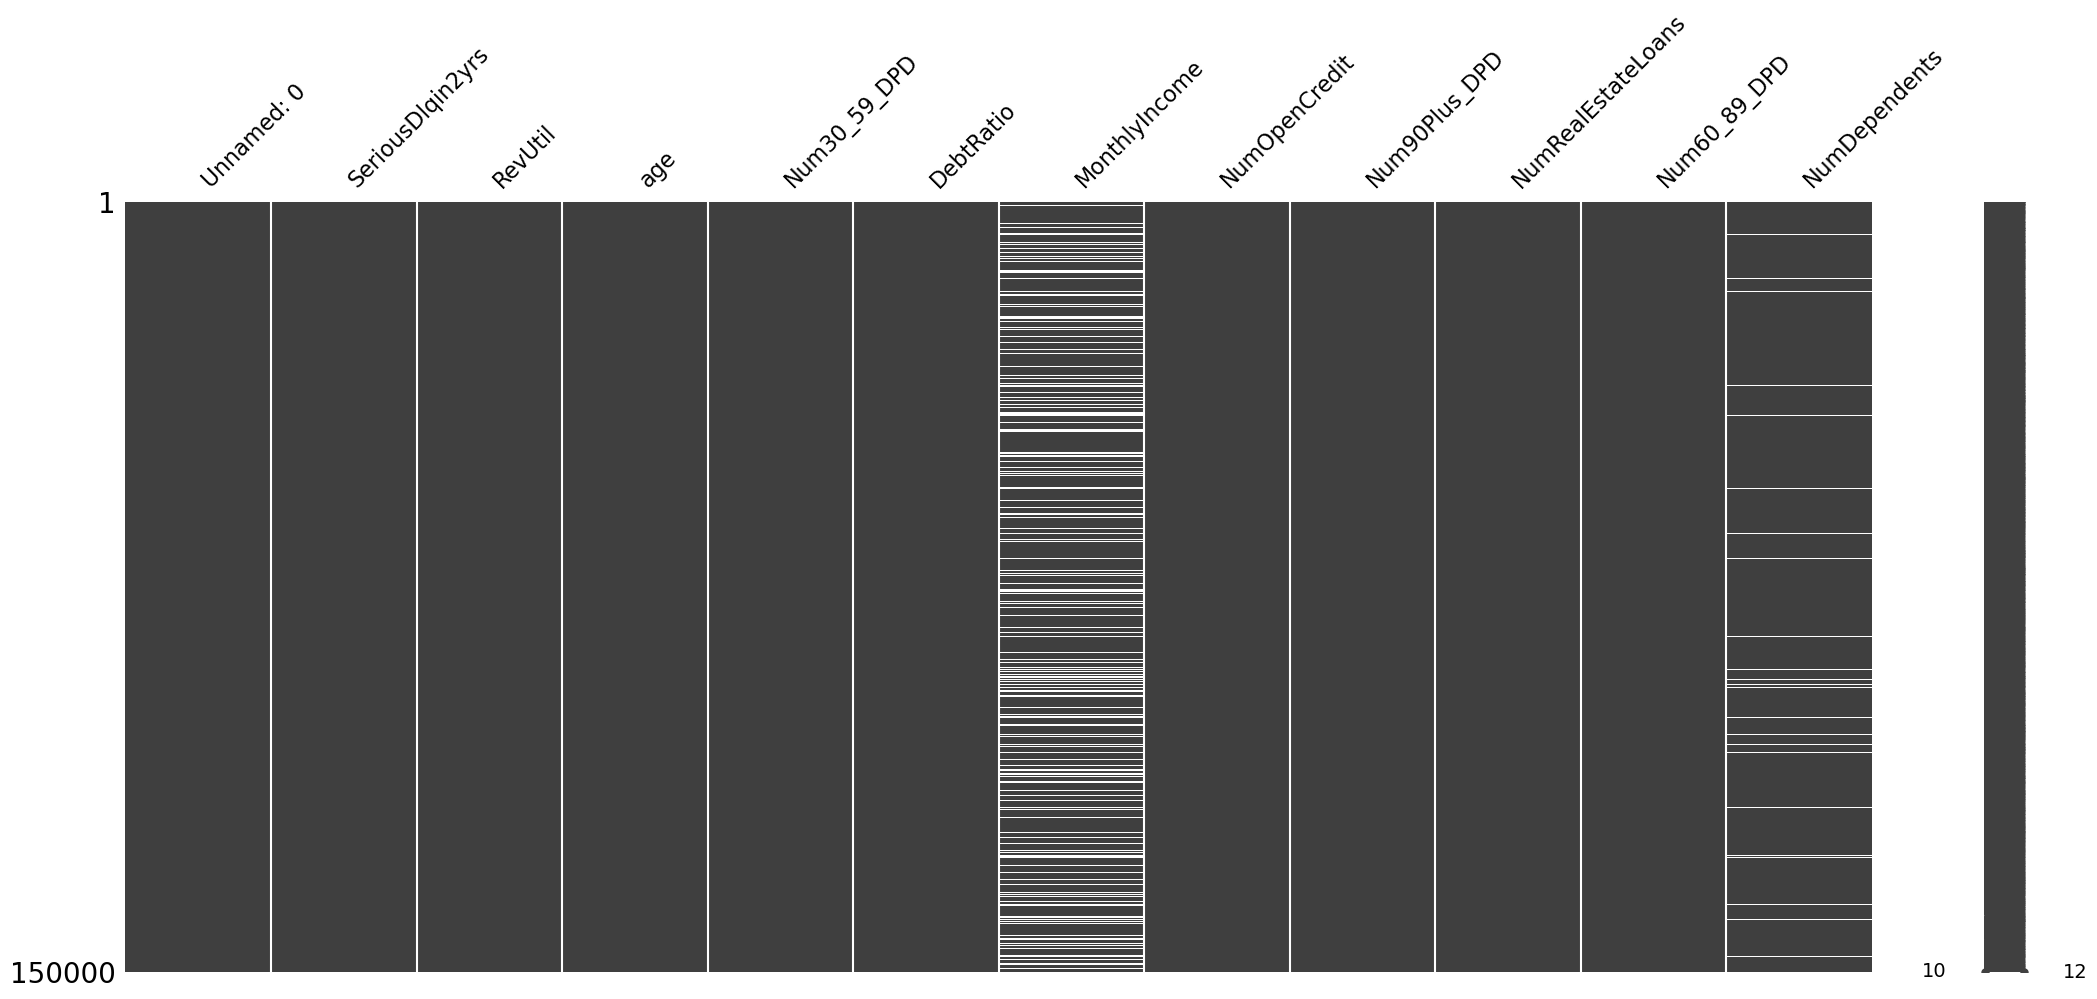

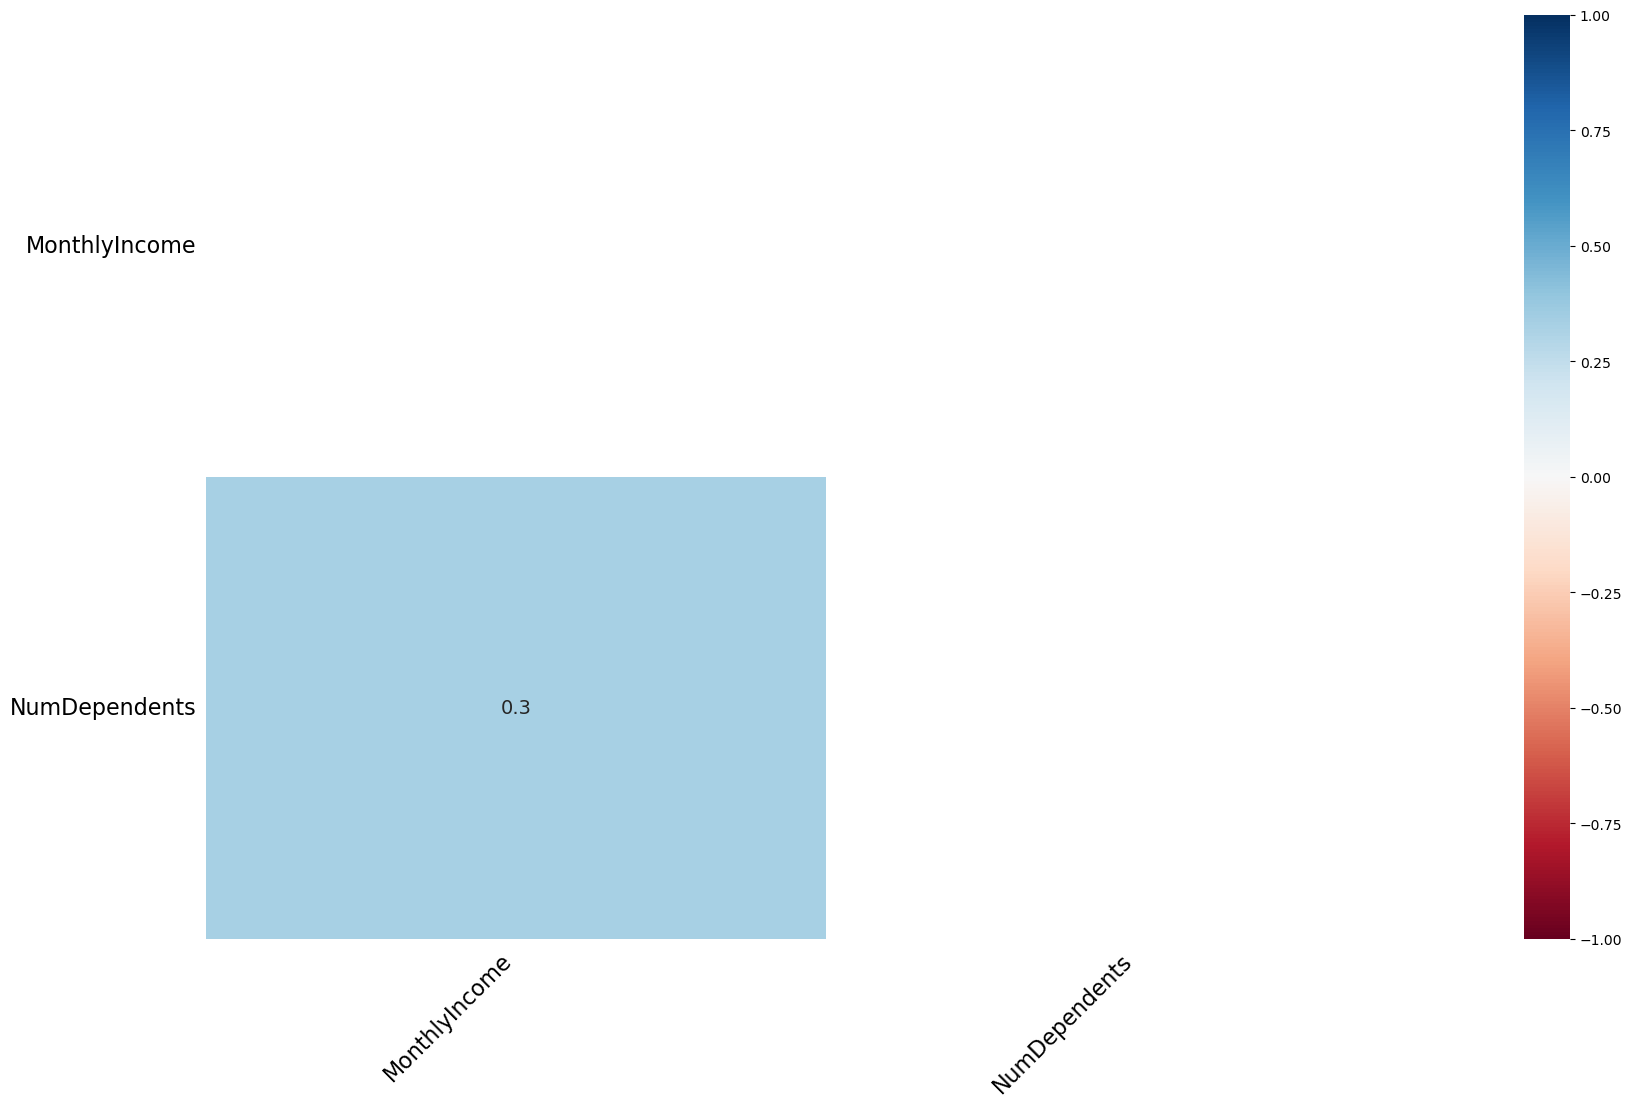

In [3]:
# --- Missing value check ---
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False))

# Visualize missingness
msno.matrix(df)
plt.show()

msno.heatmap(df)
plt.show()

In [4]:
# Check for unrealistic values (should be between 0 and ~1, occasionally up to 2)
mask_invalid = df["RevUtil"] > 2

print(f"Number of invalid RevUtil entries: {mask_invalid.sum()} "
      f"({100 * mask_invalid.mean():.3f}% of dataset)")

# Remove those rows
df = df.loc[~mask_invalid].copy()

print(f"New shape after removing invalid RevUtil rows: {df.shape}")
print("RevUtil summary after cleaning:")
print(df["RevUtil"].describe())


Number of invalid RevUtil entries: 371 (0.247% of dataset)
New shape after removing invalid RevUtil rows: (149629, 12)
RevUtil summary after cleaning:
count    149629.000000
mean          0.320335
std           0.355467
min           0.000000
25%           0.029728
50%           0.153180
75%           0.554412
max           1.998676
Name: RevUtil, dtype: float64


Num30_59_DPD unique values (top 20): [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(96), np.int64(98)] ... [np.int64(11), np.int64(12), np.int64(13), np.int64(96), np.int64(98)]
Num60_89_DPD unique values (top 20): [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(11), np.int64(96), np.int64(98)] ... [np.int64(8), np.int64(9), np.int64(11), np.int64(96), np.int64(98)]
Num90Plus_DPD unique values (top 20): [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(17), np.int64(96), np.int64(98)] ... [np.int64(14), np.int64(15), np.int64(17), np.int64(96), np.int64(98)]


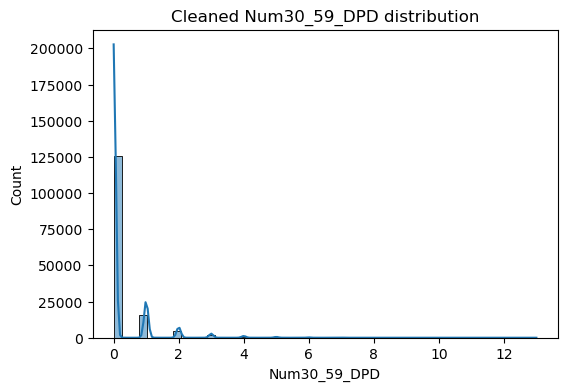

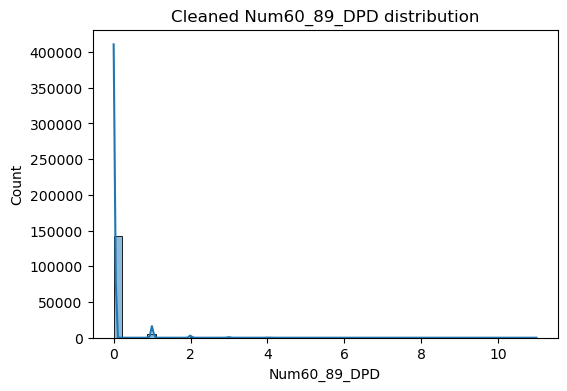

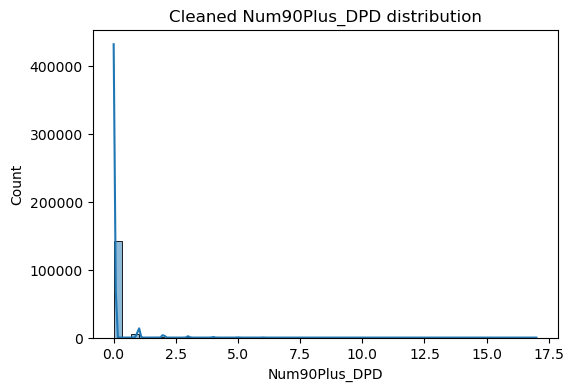

In [5]:
# --- Outlier detection for DPD counts ---
# Inspect unique values in Num30_59_DPD, Num60_89_DPD, Num90Plus_DPD
for col in ["Num30_59_DPD", "Num60_89_DPD", "Num90Plus_DPD"]:
    print(col, "unique values (top 20):", sorted(df[col].unique())[:20], "...", sorted(df[col].unique())[-5:])

# You might see extreme values like 96, 98. You could treat those as missing or cap to some max.
# Example:
def replace_sentinel_with_nan(series, sentinels=[96, 98]):
    return series.replace(sentinels, np.nan)

for col in ["Num30_59_DPD", "Num60_89_DPD", "Num90Plus_DPD"]:
    df[col] = replace_sentinel_with_nan(df[col])

# After replacement, re-inspect distributions
for col in ["Num30_59_DPD", "Num60_89_DPD", "Num90Plus_DPD"]:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col].dropna(), bins=50, kde=True)
    plt.title(f"Cleaned {col} distribution")
    plt.show()

In [6]:
col = 'Num30_59_DPD'

print(df[col].describe())

outliers = df[df[col] > 13]
print(f"Number of entries >13: {len(outliers)}")
print(outliers.head())

count    149360.000000
mean          0.245414
std           0.696911
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          13.000000
Name: Num30_59_DPD, dtype: float64
Number of entries >13: 0
Empty DataFrame
Columns: [Unnamed: 0, SeriousDlqin2yrs, RevUtil, age, Num30_59_DPD, DebtRatio, MonthlyIncome, NumOpenCredit, Num90Plus_DPD, NumRealEstateLoans, Num60_89_DPD, NumDependents]
Index: []


In [7]:
col = 'Num60_89_DPD'

print(df[col].describe())

outliers = df[df[col] > 12]
print(f"Number of entries >12: {len(outliers)}")
print(outliers.head())

count    149360.000000
mean          0.064522
std           0.328943
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          11.000000
Name: Num60_89_DPD, dtype: float64
Number of entries >12: 0
Empty DataFrame
Columns: [Unnamed: 0, SeriousDlqin2yrs, RevUtil, age, Num30_59_DPD, DebtRatio, MonthlyIncome, NumOpenCredit, Num90Plus_DPD, NumRealEstateLoans, Num60_89_DPD, NumDependents]
Index: []


In [8]:
col = 'Num90Plus_DPD'

print(df[col].describe())

outliers = df[df[col] > 8]
print(f"Number of entries >8: {len(outliers)}")
print(outliers.head())

count    149360.000000
mean          0.089803
std           0.481700
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          17.000000
Name: Num90Plus_DPD, dtype: float64
Number of entries >8: 42
       Unnamed: 0  SeriousDlqin2yrs   RevUtil  age  Num30_59_DPD    DebtRatio  \
2766         2767                 1  0.995003   30           1.0     0.176956   
2910         2911                 0  0.938586   44           1.0  1095.000000   
20726       20727                 0  0.951173   30           0.0     2.707934   
21085       21086                 1  0.981673   58           1.0     0.923397   
21879       21880                 1  1.459344   54           3.0  1718.000000   

       MonthlyIncome  NumOpenCredit  Num90Plus_DPD  NumRealEstateLoans  \
2766          4000.0              3           10.0                   0   
2910             NaN              8            9.0                   0   
20726         4700.0              7           

In [9]:
col = 'DebtRatio'

print(df[col].describe())

outliers = df[df[col] > 5]
print(f"Number of entries >5: {len(outliers)}")
print(outliers.head())

count    149629.000000
mean        352.710539
std        2038.920087
min           0.000000
25%           0.174970
50%           0.366493
75%           0.866853
max      329664.000000
Name: DebtRatio, dtype: float64
Number of entries >5: 29550
    Unnamed: 0  SeriousDlqin2yrs   RevUtil  age  Num30_59_DPD  DebtRatio  \
6            7                 0  0.305682   57           0.0     5710.0   
8            9                 0  0.116951   27           0.0       46.0   
14          15                 0  0.019657   76           0.0      477.0   
16          17                 0  0.061086   78           0.0     2058.0   
32          33                 0  0.083418   62           0.0      977.0   

    MonthlyIncome  NumOpenCredit  Num90Plus_DPD  NumRealEstateLoans  \
6             NaN              8            0.0                   3   
8             NaN              2            0.0                   0   
14            0.0              6            0.0                   1   
16            N

In [10]:
# --- Handle unrealistic DebtRatio values ---
import numpy as np

df["DebtRatio_missing_flag"] = (df["DebtRatio"] > 5).astype(int)

df.loc[df["DebtRatio"] > 5, "DebtRatio"] = np.nan

print("Number of flagged (DebtRatio > 5):", df["DebtRatio_missing_flag"].sum())
print("Remaining NaNs in DebtRatio:", df["DebtRatio"].isna().sum())
print("\nSample of flagged rows:")
print(df.loc[df["DebtRatio_missing_flag"] == 1, ["DebtRatio", "MonthlyIncome", "DebtRatio_missing_flag"]].head())


Number of flagged (DebtRatio > 5): 29550
Remaining NaNs in DebtRatio: 29550

Sample of flagged rows:
    DebtRatio  MonthlyIncome  DebtRatio_missing_flag
6         NaN            NaN                       1
8         NaN            NaN                       1
14        NaN            0.0                       1
16        NaN            NaN                       1
32        NaN            NaN                       1


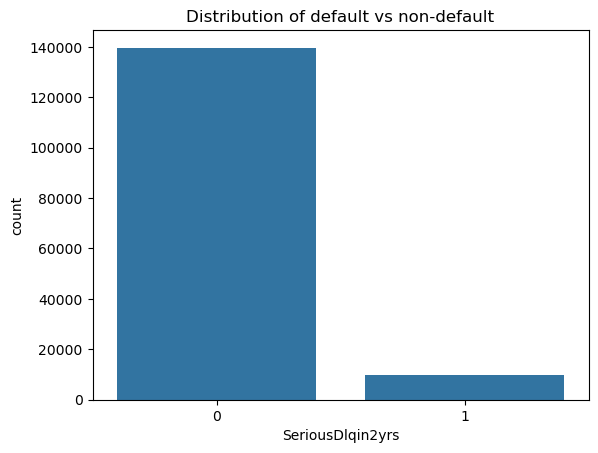

Default rate (1’s): 0.0666


In [11]:
# --- Class distribution ---
sns.countplot(x="SeriousDlqin2yrs", data=df)
plt.title("Distribution of default vs non-default")
plt.show()

# Percent default
default_rate = df["SeriousDlqin2yrs"].mean()
print(f"Default rate (1’s): {default_rate:.4f}")

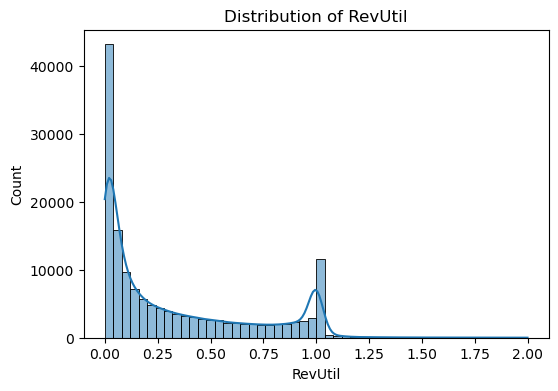

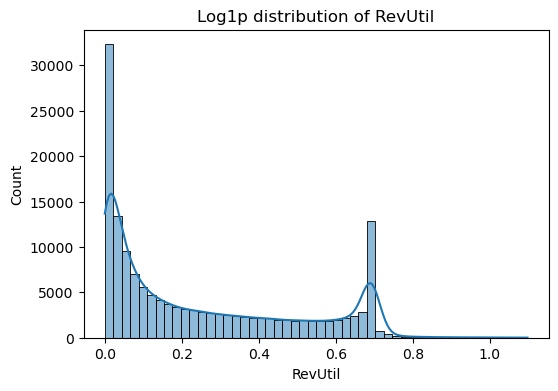

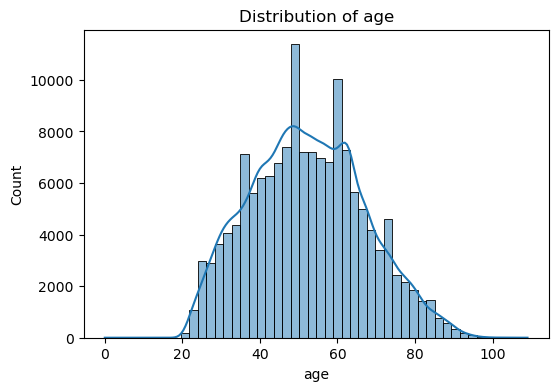

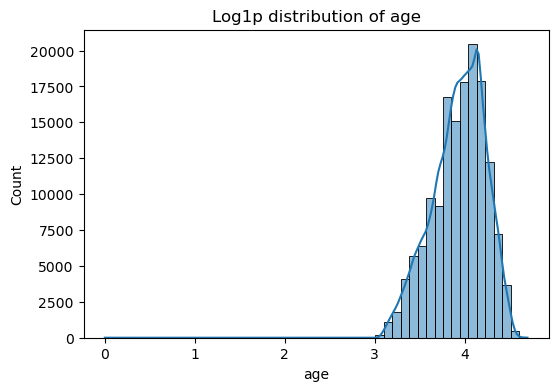

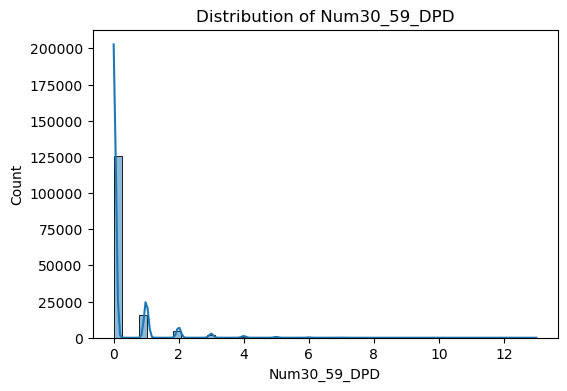

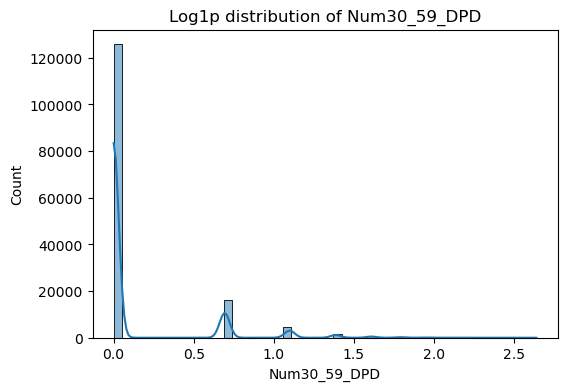

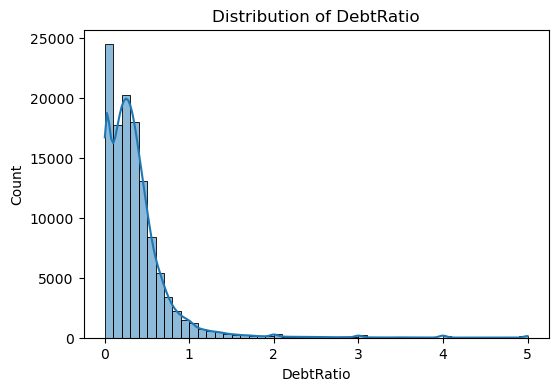

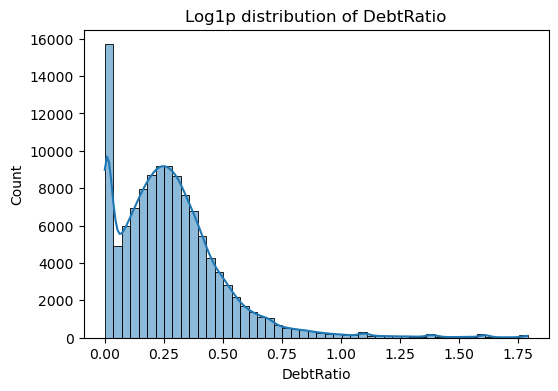

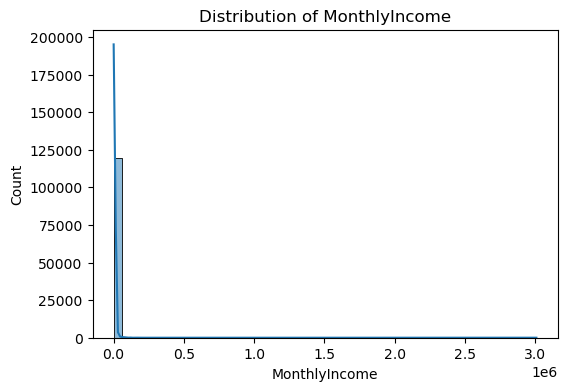

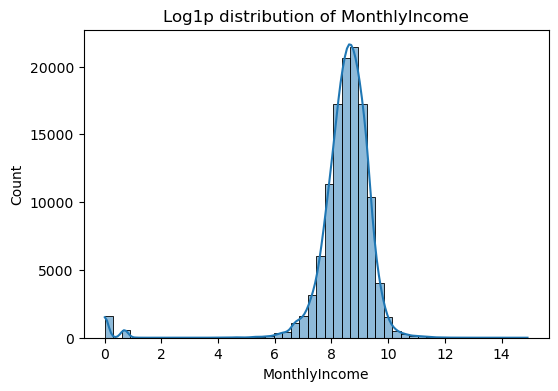

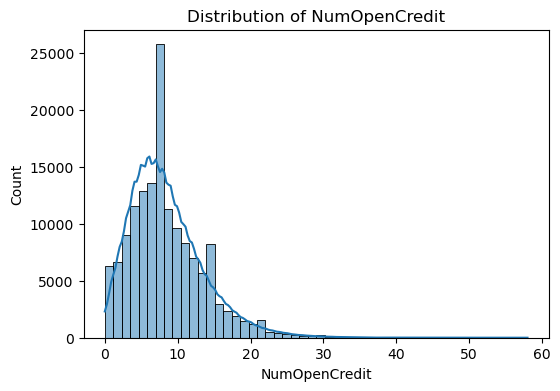

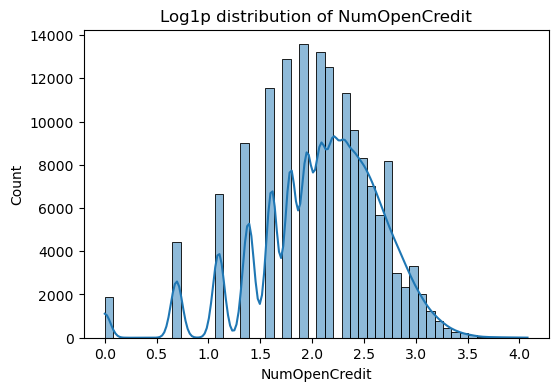

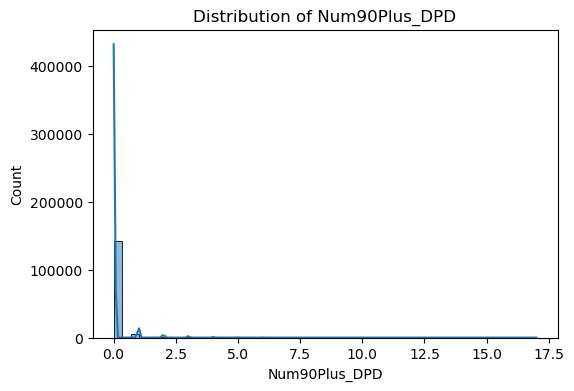

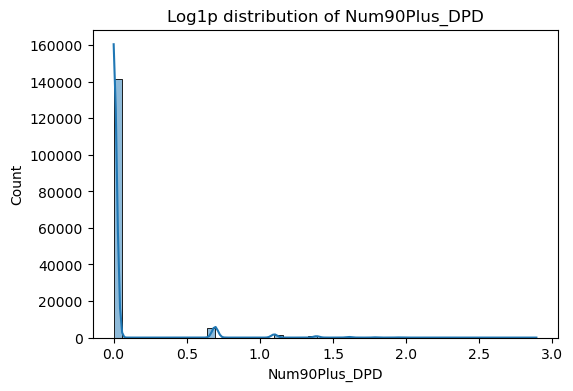

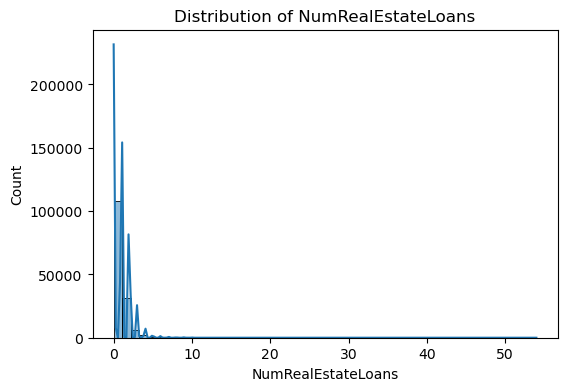

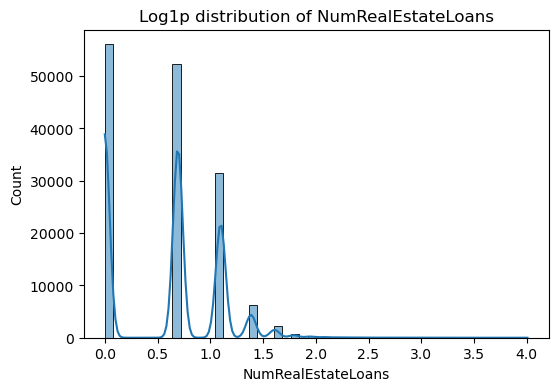

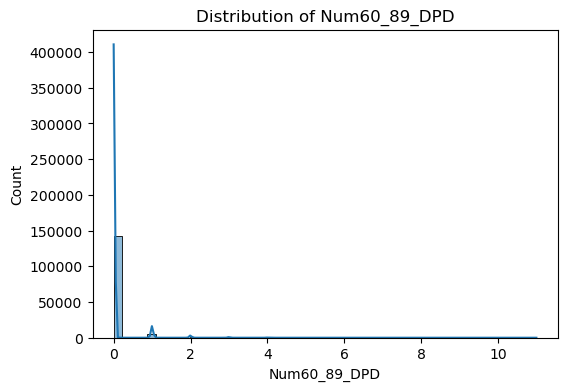

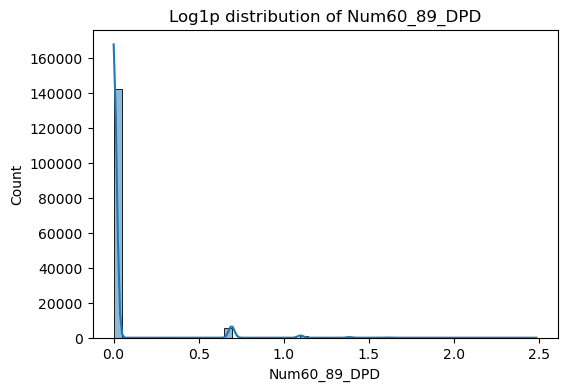

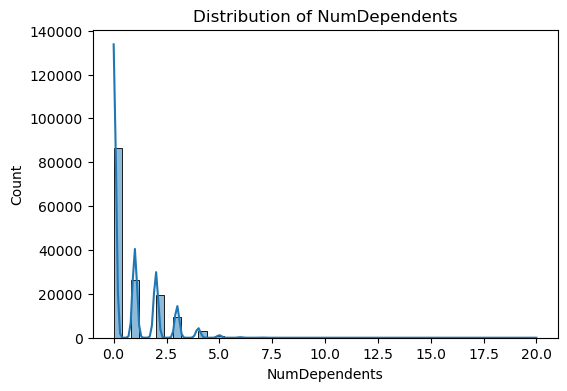

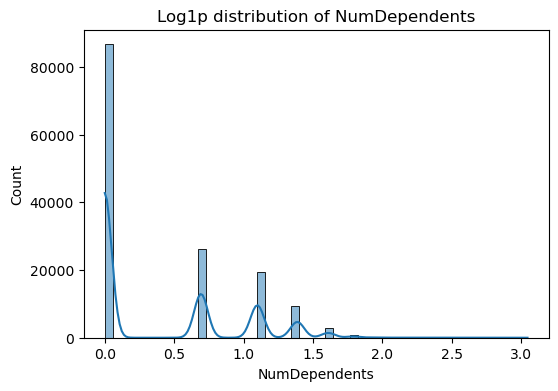

In [12]:
# --- Feature distributions (numeric) ---
num_cols = [
    "RevUtil", "age", "Num30_59_DPD", "DebtRatio", "MonthlyIncome",
    "NumOpenCredit", "Num90Plus_DPD", "NumRealEstateLoans", "Num60_89_DPD", "NumDependents"
]

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col].dropna(), kde=True, bins=50)
    plt.title(f"Distribution of {col}")
    plt.show()

    # log-scale to see if heavy skew
    plt.figure(figsize=(6,4))
    sns.histplot(np.log1p(df[col].dropna()), kde=True, bins=50)
    plt.title(f"Log1p distribution of {col}")
    plt.show()

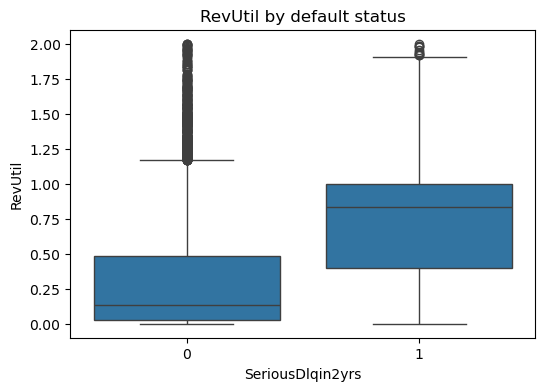

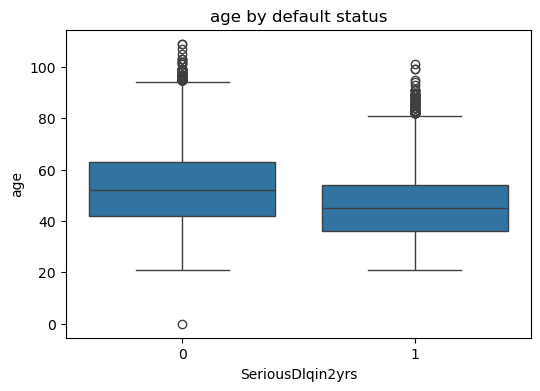

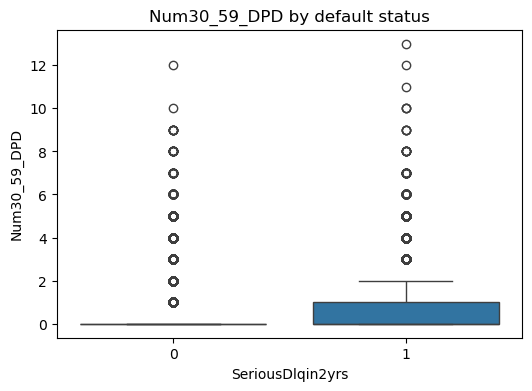

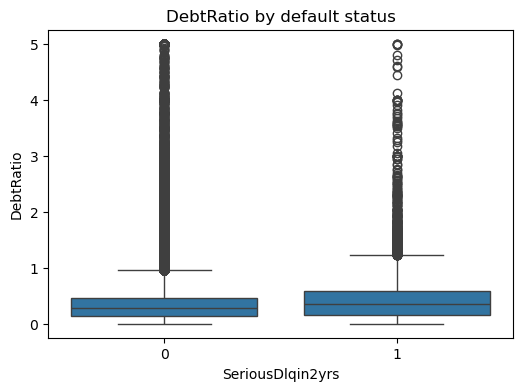

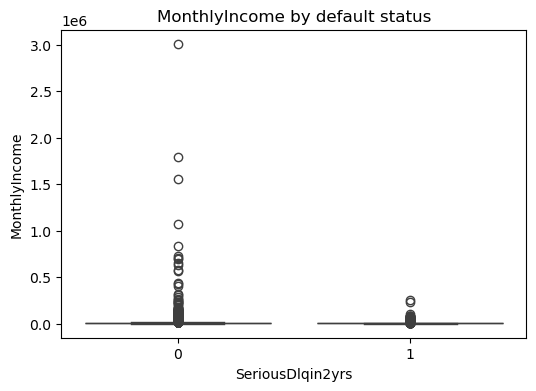

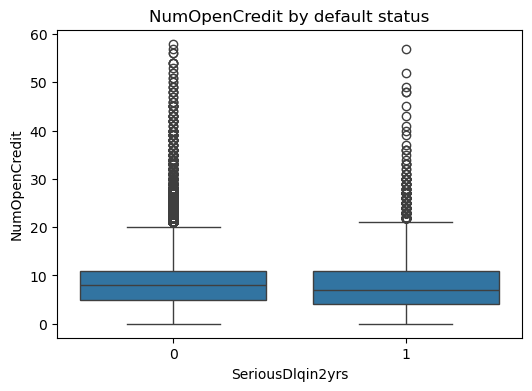

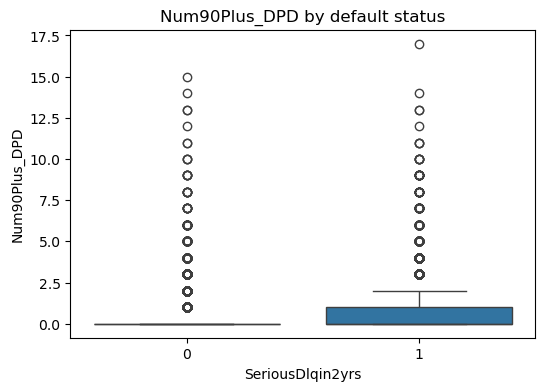

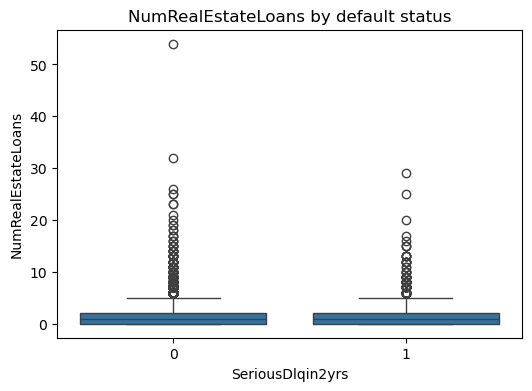

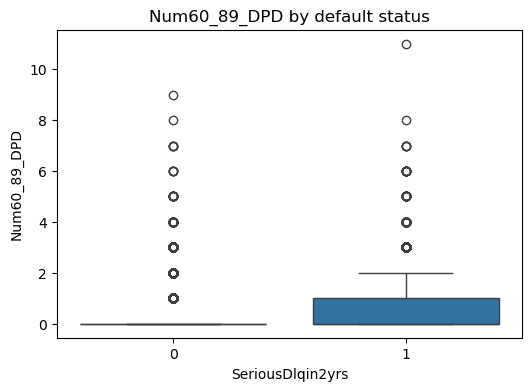

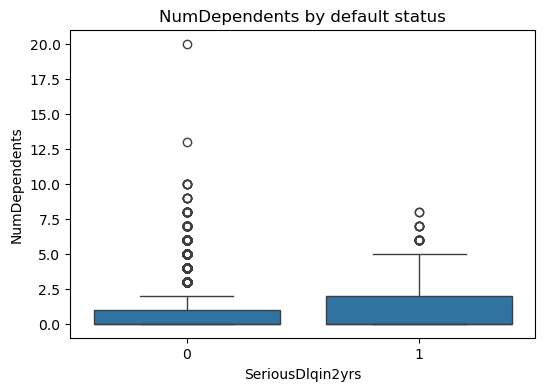

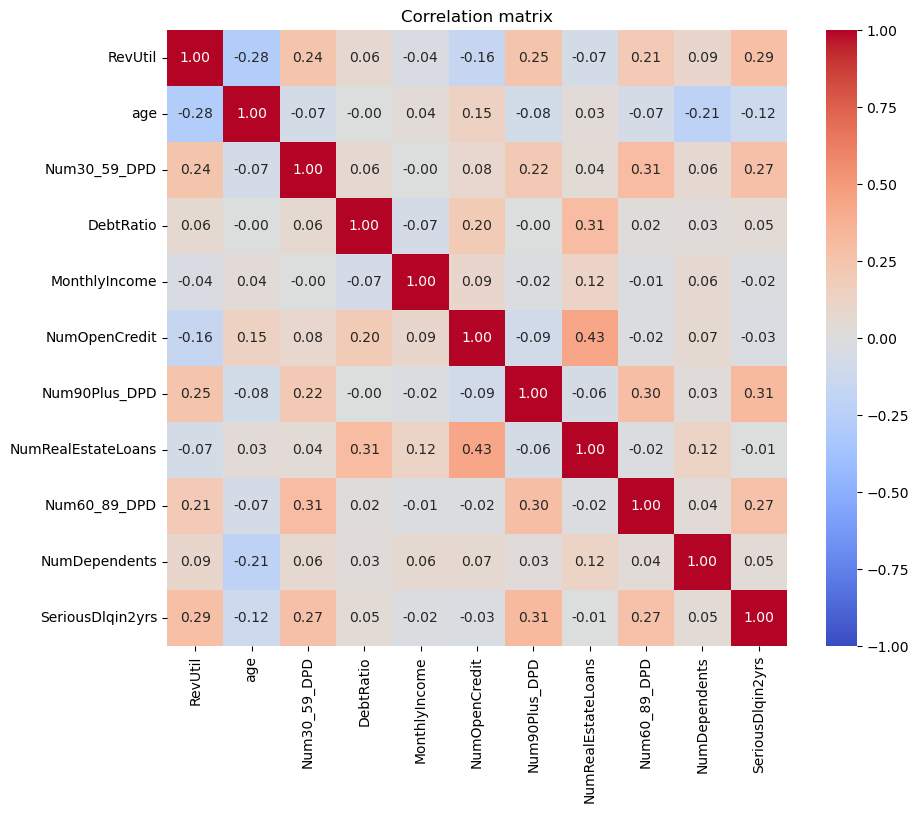

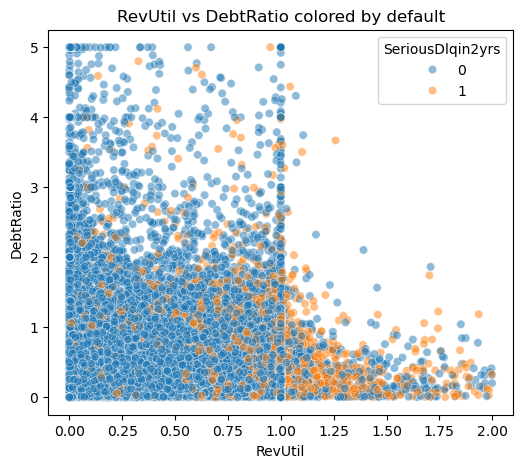

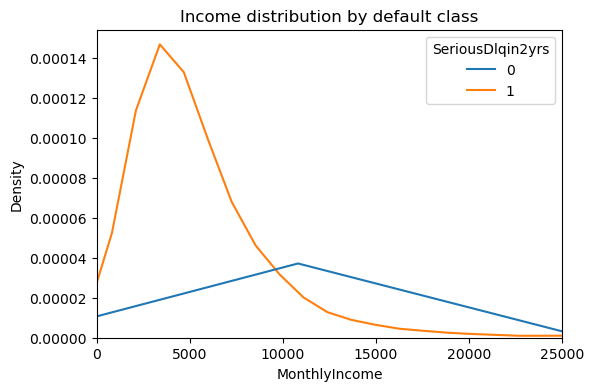

In [15]:
# ---  Bivariate plots: feature vs target ---
# boxplots 
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="SeriousDlqin2yrs", y=col, data=df)
    plt.title(f"{col} by default status")
    plt.show()

# correlation heatmap
corr = df[num_cols + ["SeriousDlqin2yrs"]].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix")
plt.show()

# scatter plots
plt.figure(figsize=(6,5))
sns.scatterplot(x="RevUtil", y="DebtRatio", hue="SeriousDlqin2yrs", data=df, alpha=0.5)
plt.title("RevUtil vs DebtRatio colored by default")
plt.show()

# distribution vs default for MonthlyIncome (since high skew)
plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x="MonthlyIncome", hue="SeriousDlqin2yrs", common_norm=False)
plt.title("Income distribution by default class")
plt.xlim(0, df["MonthlyIncome"].quantile(0.99))  # zoom in top 99th pct
plt.show()

In [16]:
mask = df['MonthlyIncome'].isna() & df['DebtRatio'].notna()

defaulted_count = df.loc[mask, 'SeriousDlqin2yrs'].sum()  # 1 = defaulted
non_defaulted_count = mask.sum() - defaulted_count      # rest are non-defaulted

print(f"Rows with missing MonthlyIncome but present DebtRatio:")
print(f" - Defaulted: {defaulted_count}")
print(f" - Non-defaulted: {non_defaulted_count}")


Rows with missing MonthlyIncome but present DebtRatio:
 - Defaulted: 126
 - Non-defaulted: 2308


In [18]:
from scipy.stats import chi2_contingency

ct = pd.crosstab(df['DebtRatio_missing_flag'], df['SeriousDlqin2yrs'], margins=True)
print("Crosstab of DebtRatio_missing_flag vs Default:")
print(ct)

default_rates = df.groupby('DebtRatio_missing_flag')['SeriousDlqin2yrs'].mean()
print("\nDefault rate by DebtRatio_missing_flag:")
print(default_rates)

chi2, p, dof, expected = chi2_contingency(pd.crosstab(df['DebtRatio_missing_flag'], df['SeriousDlqin2yrs']))
print(f"\nChi-squared test:\nChi2 statistic = {chi2:.3f}, p-value = {p:.3g}, degrees of freedom = {dof}")
print("Expected frequencies:")
print(expected)


Crosstab of DebtRatio_missing_flag vs Default:
SeriousDlqin2yrs             0     1     All
DebtRatio_missing_flag                      
0                       111740  8339  120079
1                        27917  1633   29550
All                     139657  9972  149629

Default rate by DebtRatio_missing_flag:
DebtRatio_missing_flag
0    0.069446
1    0.055262
Name: SeriousDlqin2yrs, dtype: float64

Chi-squared test:
Chi2 statistic = 76.468, p-value = 2.24e-18, degrees of freedom = 1
Expected frequencies:
[[112076.35487105   8002.64512895]
 [ 27580.64512895   1969.35487105]]


In [19]:
df.loc[df['DebtRatio'] == 0, 'MonthlyIncome'].describe()


count      2491.000000
mean       4047.162987
std       13091.184708
min           0.000000
25%        1600.000000
50%        2916.000000
75%        4939.000000
max      629000.000000
Name: MonthlyIncome, dtype: float64

In [56]:
numeric_features = ['age', 'Num30_59_DPD', 'NumOpenCredit',
                    'Num90Plus_DPD', 'NumRealEstateLoans',
                    'Num60_89_DPD', 'NumDependents']
skewed_features = ['DebtRatio', 'MonthlyIncome']
revutil_col = 'RevUtil'
binary_features = ['DebtRatio_missing_flag']

X_full = df[numeric_features + skewed_features + [revutil_col] + binary_features]
y_full = df['SeriousDlqin2yrs']

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

class RevUtilSplitter(BaseEstimator, TransformerMixin):
    def __init__(self, low_thresh=0.1, high_thresh=0.95):
        self.low_thresh = low_thresh
        self.high_thresh = high_thresh

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()
        col = X_new.columns[0]  # assumes only RevUtil column is passed
        X_new['RevUtil_zero'] = (X_new[col] < self.low_thresh).astype(int)
        X_new['RevUtil_one'] = (X_new[col] > self.high_thresh).astype(int)
        X_new['RevUtil_mid'] = X_new[col].copy()
        X_new.loc[(X_new[col] < self.low_thresh) | (X_new[col] > self.high_thresh), 'RevUtil_mid'] = 0
        return X_new[['RevUtil_mid', 'RevUtil_zero', 'RevUtil_one']]


preprocessor = ColumnTransformer(transformers=[
    ('revutil', RevUtilSplitter(), [revutil_col]),
    ('skewed', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('log', Log1pWrapper(np.log1p, validate=True))
    ]), skewed_features),
    ('numeric', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', RobustScaler())
    ]), numeric_features),
    ('binary', SimpleImputer(strategy='constant', fill_value=0), binary_features)
], remainder='drop')

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('clf', LogisticRegression(penalty='l1', solver='liblinear', C=0.01, max_iter=1000))
])

pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('revutil', RevUtilSplitter(),
                                                  ['RevUtil']),
                                                 ('skewed',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('log',
                                                                   Log1pWrapper(func=<ufunc 'log1p'>,
                                                                                validate=True))]),
                                                  ['DebtRatio',
                                                   'MonthlyIncome']),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'Num30_59_DPD',
                                                   'NumOpenCredit',
                                                   'Num90Plus_DPD',
                                                   'NumRealEstateLoans',
                                                   'Num60_89_DPD',
                                                   'NumDependents']),
                                                 ('binary',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['DebtRatio_missing_flag'])])),
                ('clf',
                 LogisticRegression(C=0.01, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

In [57]:
# Predict 
y_val_pred = pipeline.predict_proba(X_val)[:,1]

# --- ROC AUC ---
roc_auc = roc_auc_score(y_val, y_val_pred)
print("Validation ROC AUC:", roc_auc)

# --- PR AUC ---
precision_vals, recall_vals, thresholds = precision_recall_curve(y_val, y_val_pred)
pr_auc = calc_auc(recall_vals, precision_vals)
print("Validation PR AUC:", pr_auc)

# --- Precision & Recall at 0.5 threshold ---
y_val_pred_label_05 = (y_val_pred >= 0.5).astype(int)
precision_05 = precision_score(y_val, y_val_pred_label_05)
recall_05 = recall_score(y_val, y_val_pred_label_05)
print("Precision (threshold=0.5):", precision_05)
print("Recall (threshold=0.5):", recall_05)

# --- Optimal threshold based on F1-score ---
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

y_val_pred_label_opt = (y_val_pred >= best_threshold).astype(int)
best_precision = precision_score(y_val, y_val_pred_label_opt)
best_recall = recall_score(y_val, y_val_pred_label_opt)

print(f"Optimal threshold: {best_threshold:.3f}")
print(f"F1-score at optimal threshold: {best_f1:.3f}")
print(f"Precision at optimal threshold: {best_precision:.3f}")
print(f"Recall at optimal threshold: {best_recall:.3f}")

# --- KS statistic ---
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_label_opt)
ks_statistic = np.max(tpr - fpr)
print(f"KS Statistic: {ks_statistic :.3f}")

# --- Brier Score Loss ---
brier = brier_score_loss(y_val, y_val_pred)
print(f"Brier Score at optimal threshold: {brier:.4f}")

# --- Access coefficients ---
feature_names = (
    ['RevUtil_mid', 'RevUtil_zero', 'RevUtil_one'] +
    skewed_features + numeric_features + binary_features
)
coefs = pipeline.named_steps['clf'].coef_[0]
for name, coef in zip(feature_names, coefs):
    print(name, coef)

Validation ROC AUC: 0.8488277825744167
Validation PR AUC: 0.3810302555090217
Precision (threshold=0.5): 0.6301075268817204
Recall (threshold=0.5): 0.1469408224674022
Optimal threshold: 0.160
F1-score at optimal threshold: 0.430
Precision at optimal threshold: 0.405
Recall at optimal threshold: 0.459
KS Statistic: 0.411
Brier Score at optimal threshold: 0.0505
RevUtil_mid 1.2063108470931212
RevUtil_zero -0.41442896807902757
RevUtil_one 1.490898398190742
DebtRatio 0.11287908140133139
MonthlyIncome -0.040442623791063975
age -0.3829358447692643
Num30_59_DPD 0.43948466122800095
NumOpenCredit 0.0964331654103877
Num90Plus_DPD 0.6191588431084286
NumRealEstateLoans 0.08647032813304184
Num60_89_DPD 0.5653158877146649
NumDependents 0.013444335806885168
DebtRatio_missing_flag -0.29627329865889307


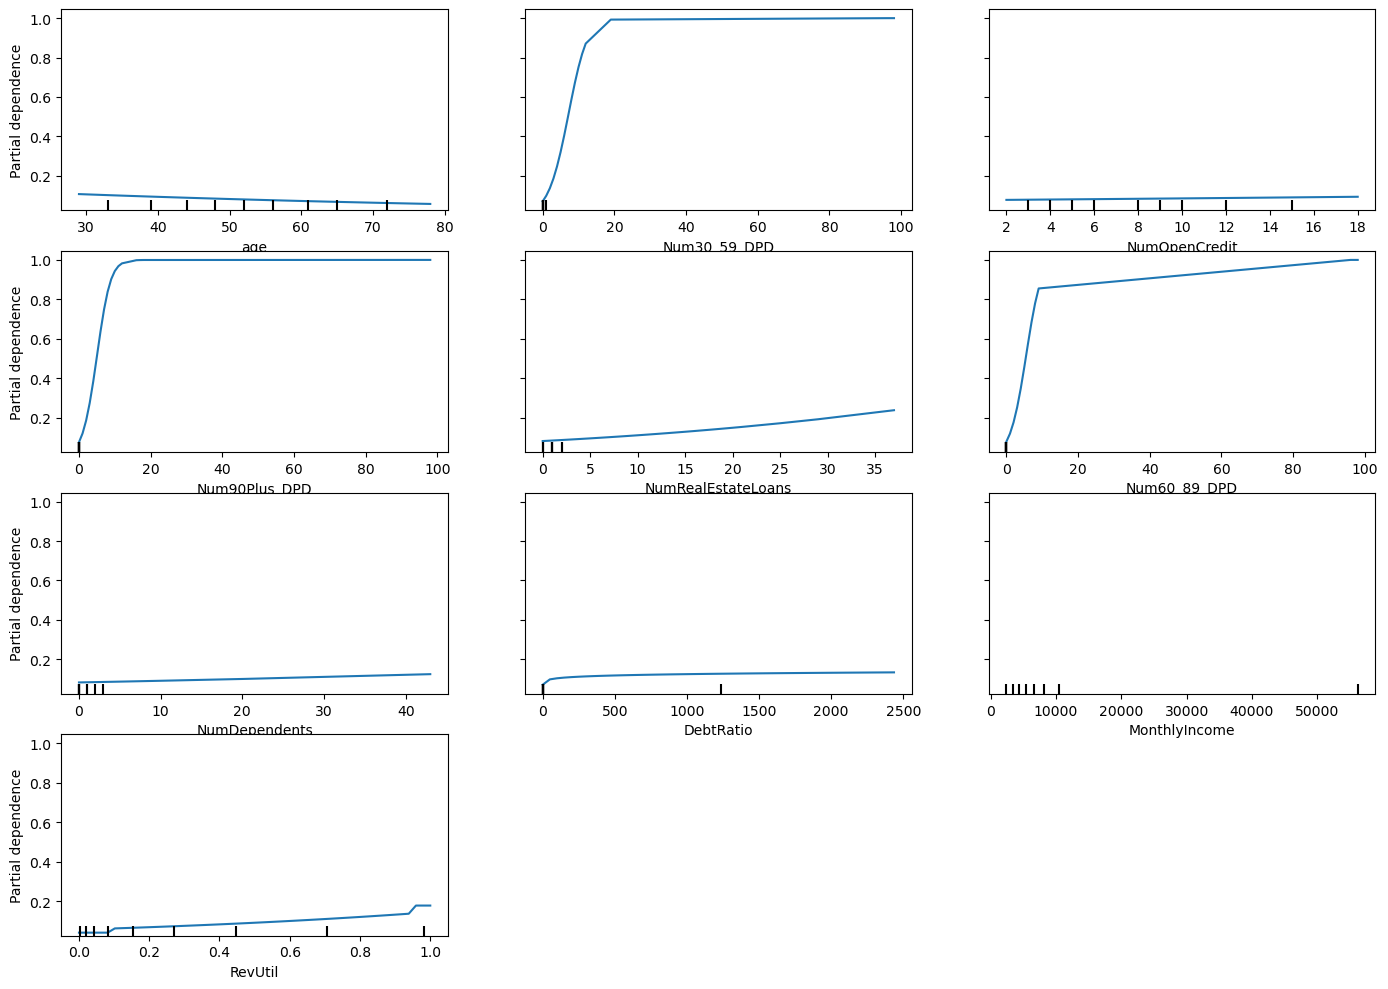

In [63]:
features_to_plot = [
    'age', 'Num30_59_DPD', 'NumOpenCredit',
    'Num90Plus_DPD', 'NumRealEstateLoans',
    'Num60_89_DPD', 'NumDependents',
    'DebtRatio', 'MonthlyIncome', 'RevUtil'
]

fig, ax = plt.subplots(figsize=(14, 10))

display = PartialDependenceDisplay.from_estimator(
    pipeline,
    X_test,
    features=features_to_plot,
    kind='average',
    grid_resolution=50,
    n_cols=3,  
    ax=ax       
)

plt.tight_layout()
plt.show()


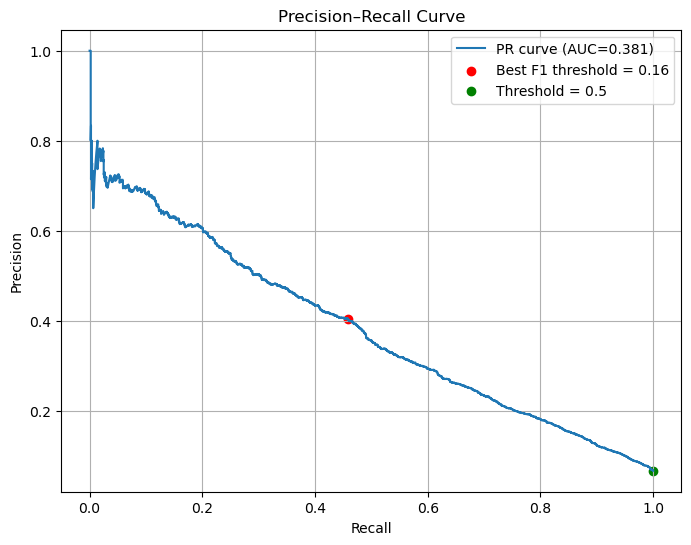

In [64]:
# --- Plot Precision–Recall Curve ---
plt.figure(figsize=(8,6))
plt.plot(recall_vals, precision_vals, label=f'PR curve (AUC={pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')

# Mark thresholds
plt.scatter(recall_vals[best_idx], precision_vals[best_idx],
            color='red', label=f'Best F1 threshold = {best_threshold:.2f}')
# Find point for threshold=0.5 (closest)
thresh_idx_05 = np.argmin(np.abs(thresholds - 0.5))
plt.scatter(recall_vals[thresh_idx_05], precision_vals[thresh_idx_05],
            color='green', label='Threshold = 0.5')

plt.legend()
plt.grid(True)
plt.show()


Predictions saved as cs-test-predictions.csv


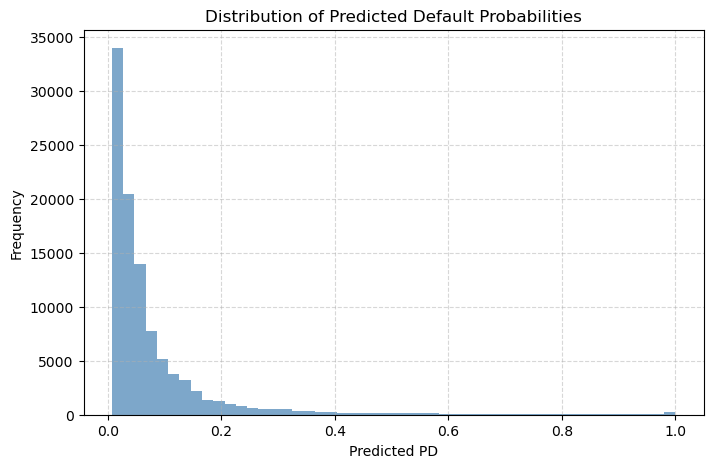

In [65]:
# --- Load test data ---
test_path = r"C:\Users\alexa\Documents\Credit Risk\Kaggle retail\cs-test.csv"
test_df = pd.read_csv(test_path)

test_df = test_df.rename(columns={
    "NumberOfTime30-59DaysPastDueNotWorse": "Num30_59_DPD",
    "NumberOfTime60-89DaysPastDueNotWorse": "Num60_89_DPD",
    "NumberOfTimes90DaysLate": "Num90Plus_DPD",
    "NumberRealEstateLoansOrLines": "NumRealEstateLoans",
    "NumberOfOpenCreditLinesAndLoans": "NumOpenCredit",
    "RevolvingUtilizationOfUnsecuredLines": "RevUtil",
    "NumberOfDependents": "NumDependents"
})

test_df["DebtRatio_missing_flag"] = (df["DebtRatio"] > 5).astype(int)

# --- Align columns with training data ---
X_test = test_df.drop(columns=['SeriousDlqin2yrs'], errors='ignore')
y_test = test_df['SeriousDlqin2yrs'] if 'SeriousDlqin2yrs' in test_df.columns else None

y_test_pred = pipeline.predict_proba(X_test)[:, 1]

# --- Save predictions to file ---
output_df = test_df.copy()
output_df['PD_pred'] = y_test_pred
output_df.to_csv(r"C:\Users\alexa\Documents\Credit Risk\Kaggle retail\cs-test-predictions.csv", index=False)
print("Predictions saved as cs-test-predictions.csv")

# --- Plot predicted probability distribution ---
plt.figure(figsize=(8,5))
plt.hist(y_test_pred, bins=50, color='steelblue', alpha=0.7)
plt.title("Distribution of Predicted Default Probabilities")
plt.xlabel("Predicted PD")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


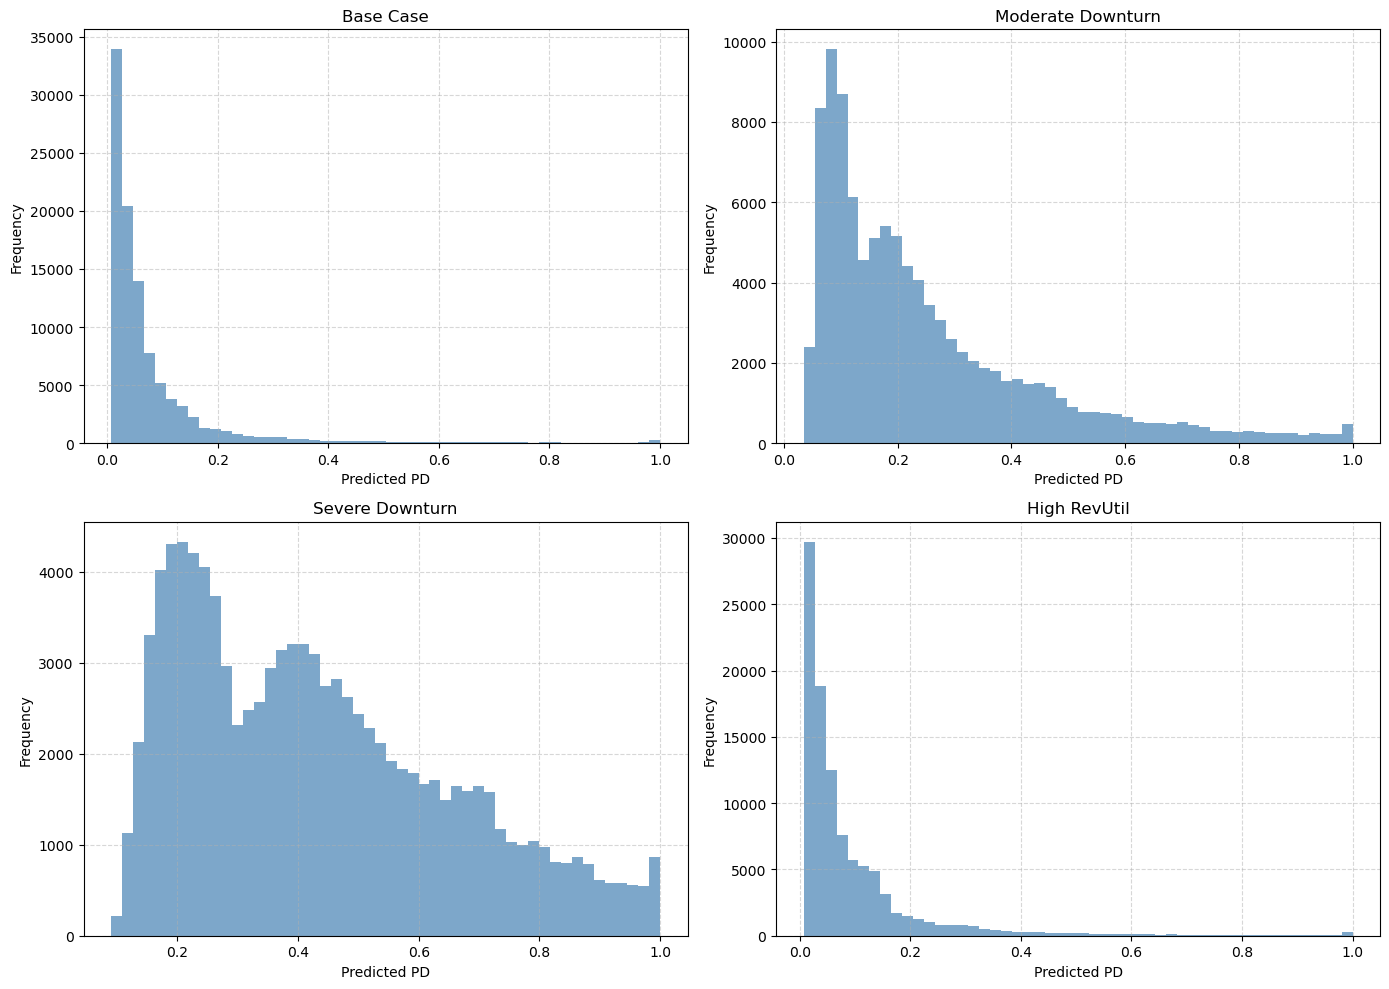

In [67]:
# --- Base case ---
y_base_pred = pipeline.predict_proba(X_test)[:, 1]

# --- Scenario 1: Moderate downturn ---
X_stress1 = X_test.copy()
X_stress1['MonthlyIncome'] *= 0.8       # incomes drop by 20%
X_stress1['DebtRatio'] *= 1.5           # debt ratio rises by 50%
X_stress1['Num30_59_DPD'] += 1
X_stress1['Num60_89_DPD'] += 1
X_stress1['Num90Plus_DPD'] += 1
y_stress1_pred = pipeline.predict_proba(X_stress1)[:, 1]

# --- Scenario 2: Severe downturn ---
X_stress2 = X_test.copy()
X_stress2['MonthlyIncome'] *= 0.5       # incomes drop by 50%
X_stress2['DebtRatio'] *= 2.0           # debt ratio doubles
X_stress2['Num30_59_DPD'] += 2
X_stress2['Num60_89_DPD'] += 2
X_stress2['Num90Plus_DPD'] += 1
y_stress2_pred = pipeline.predict_proba(X_stress2)[:, 1]

# --- Scenario 3: Revolving credit spike ---
X_stress3 = X_test.copy()
X_stress3['RevUtil'] *= 1.5             # higher utilization
y_stress3_pred = pipeline.predict_proba(X_stress3)[:, 1]

# --- Plot distributions ---
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()

scenarios = {
    "Base Case": y_base_pred,
    "Moderate Downturn": y_stress1_pred,
    "Severe Downturn": y_stress2_pred,
    "High RevUtil": y_stress3_pred
}

for ax, (title, preds) in zip(axes, scenarios.items()):
    ax.hist(preds, bins=50, color='steelblue', alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('Predicted PD')
    ax.set_ylabel('Frequency')
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [68]:
scenarios = {
    "Base Case": y_base_pred,
    "Moderate Downturn": y_stress1_pred,
    "Severe Downturn": y_stress2_pred,
    "High RevUtil": y_stress3_pred
}

print("Expected PDs for each scenario:")
for title, preds in scenarios.items():
    expected_pd = np.mean(preds)
    median_pd = np.median(preds)
    p90_pd = np.percentile(preds, 90)
    print(f"{title}: mean={expected_pd:.4f}, median={median_pd:.4f}, 90th percentile={p90_pd:.4f}")


Expected PDs for each scenario:
Base Case: mean=0.0831, median=0.0430, 90th percentile=0.1777
Moderate Downturn: mean=0.2512, median=0.1899, 90th percentile=0.5307
Severe Downturn: mean=0.4330, median=0.3979, 90th percentile=0.7610
High RevUtil: mean=0.0961, median=0.0493, 90th percentile=0.2140
